In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# open train set csv as dataframe
data = pd.read_csv('/content/drive/MyDrive/ESA_DATA/21_months.train.csv')
print(data.shape)
data.head()
# non-target channels: 1-11, 53-56, 67-69, out of 76 total channels (the others are target channels)
# telecommands are binary (0 or 1)

(1840321, 175)


,timestamp,channel_1,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15,channel_16,channel_17,...,is_anomaly_telecommand_350,is_anomaly_telecommand_351,is_anomaly_telecommand_352,is_anomaly_telecommand_353,is_anomaly_telecommand_354,is_anomaly_telecommand_36,is_anomaly_telecommand_376,is_anomaly_telecommand_38,is_anomaly_telecommand_39,is_anomaly_telecommand_40
0,2000-01-01 00:00:00,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0,0,0,0,0,0,0,0,0,0
1,2000-01-01 00:00:30,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0,0,0,0,0,0,0,0,0,0
2,2000-01-01 00:01:00,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0,0,0,0,0,0,0,0,0,0
3,2000-01-01 00:01:30,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0,0,0,0,0,0,0,0,0,0
4,2000-01-01 00:02:00,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# count number channel containing at least 1 anomaly using the binary columns "is_anomaly_channel{n}"
anomalies = data.filter(like='is_anomaly_channel')
mask = anomalies.sum() != 0
len(anomalies.columns[mask])

53

In [4]:
mask_nominal = anomalies.sum() == 0
len(anomalies.columns[mask_nominal])

23

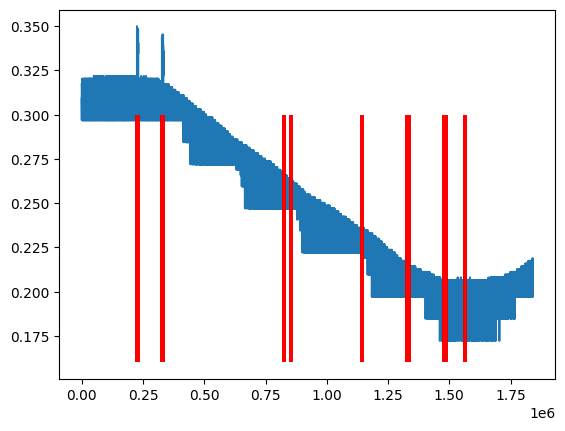

In [5]:
plt.plot(data['channel_12'])
# plot a vertical line where columns "is_anomaly_channel_12" is greater than 0
plt.vlines(data.index[data['is_anomaly_channel_12'] != 0], ymin=0.16, ymax=0.3, color='red')

In [6]:
data['is_anomaly_channel_12'].unique() # nominal, anomaly, rare_event, communication_gap

array([0, 1, 2, 3])

In [55]:
#extract consecutive points from "train" such that there are no anomalies in any of the channels, therefore splitting the data into several 2 subseries (before the anomaly occurs and after up to the next anomaly) for each anomaly
def extract_clean_consecutive_timepoints(train_data):
    # find the indices of the anomalies
    anomaly_indices = train_data.index[train_data.filter(like='is_anomaly_channel').sum(axis=1) != 0]
    # create a list to store the subseries
    subseries = []
    # initialize the start index of the subseries
    start_idx = -1
    # iterate over the anomaly indices
    for idx in anomaly_indices:
        # extract the subseries from the start index to the anomaly index
        if idx - start_idx == 1:
            start_idx = idx
            continue
        subseries.append(train_data.iloc[start_idx + 1:idx].filter(regex='^channel'))
        # update the start index to the next index
        start_idx = idx
    # extract the last subseries from the last anomaly index to the end of the data
    subseries.append(train_data.iloc[start_idx+1:].filter(regex='^channel'))
    return subseries


In [58]:
def segment_time_series(dataframes, window_length=256, overlap=0.5):
    """
    Segments a list of dataframes representing time series into windows of fixed length with overlap.
    Discards dataframes shorter than the window length and trims any remainder for imperfect divisions.

    Parameters:
    - dataframes: List of pandas DataFrame objects to segment.
    - window_length: The length of each segment (default: 256).
    - overlap: Fraction of overlap between consecutive windows (default: 0.5).

    Returns:
    - List of pandas DataFrame objects, each with the specified window length.
    """
    segmented_dfs = []
    step = int(window_length * (1 - overlap))  # Step size based on overlap

    for df in dataframes:
        length = len(df)
        if length < window_length:
            continue  # Discard short time series
        num_windows = (length - window_length) // step + 1  # Calculate number of full windows (similar to convolution shape calculation)
        for i in range(num_windows):
            start = i * step
            end = start + window_length
            segmented_dfs.append(df.iloc[start:end])

    return segmented_dfs

In [ ]:
# divide the dataframe timeseries into training and test set (two halves)
def train_test_division(df, p=0.54):
    index = int(len(df)*p)
    training_df = df.iloc[:index]
    test_df = df.iloc[index:]
    training_series = extract_clean_consecutive_timepoints(training_df)
    training_series = segment_time_series(training_series)
    # for training keep only columns starting with "channel_", for test keep those and also "is_anomaly_channel"
    test_df = test_df.filter(regex='^channel|^is_anomaly_channel')
    test_series = segment_time_series([test_df])
    # divide the whole dataframe into non_anomalous subseries for the training set, keep
    return training_series, test_series

training_series, test_series = train_test_division(data)
print(len(training_series))
print(len(test_series))

In [69]:
test_series[42]

,channel_1,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15,channel_16,channel_17,channel_18,...,is_anomaly_channel_7,is_anomaly_channel_70,is_anomaly_channel_71,is_anomaly_channel_72,is_anomaly_channel_73,is_anomaly_channel_74,is_anomaly_channel_75,is_anomaly_channel_76,is_anomaly_channel_8,is_anomaly_channel_9
999149,0.13791,0.0,0.0,0.248549,0.301578,0.267029,0.090177,0.680347,0.275598,0.284645,...,0,0,0,0,0,0,0,0,0,0
999150,0.13791,0.0,0.0,0.248549,0.301578,0.267029,0.090177,0.680347,0.275598,0.284645,...,0,0,0,0,0,0,0,0,0,0
999151,0.13791,0.0,0.0,0.248549,0.301578,0.267029,0.088891,0.678508,0.275598,0.284645,...,0,0,0,0,0,0,0,0,0,0
999152,0.13791,0.0,0.0,0.248549,0.301578,0.267029,0.088891,0.678508,0.275598,0.284645,...,0,0,0,0,0,0,0,0,0,0
999153,0.13791,0.0,0.0,0.248549,0.301578,0.267029,0.088891,0.678508,0.275598,0.284645,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999400,0.13791,0.0,0.0,0.243869,0.298458,0.267029,0.088891,0.687702,0.277106,0.290674,...,0,0,0,0,0,0,0,0,0,0
999401,0.13791,0.0,0.0,0.243869,0.298458,0.267029,0.088891,0.687702,0.277106,0.290674,...,0,0,0,0,0,0,0,0,0,0
999402,0.13791,0.0,0.0,0.243869,0.298458,0.267029,0.088891,0.687702,0.277106,0.290674,...,0,0,0,0,0,0,0,0,0,0
999403,0.13791,0.0,0.0,0.243869,0.298458,0.267029,0.088891,0.678508,0.277106,0.292182,...,0,0,0,0,0,0,0,0,0,0


In [17]:
for i in range(len(train_series)):
    if train_series[i].filter(like='is_anomaly_channel').sum().sum() != 0:
        print('ANOMALY FOUND something went wrong')
print("END")
print(len(train_series))

END
28


0.0    1840306
1.0         15
Name: telecommand_354, dtype: int64